# Import libraries

In [ ]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 10)})
sns.set(font_scale=2)
sns.set_style("whitegrid")

import matplotlib.ticker as ticker
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.model_selection import TimeSeriesSplit


# import numpy as np 
# from plotly.graph_objects import *
# from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(connected=True)

# from sklearn.preprocessing import MinMaxScaler

# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import Ridge
# from sklearn.multioutput import MultiOutputRegressor

# from sklearn.metrics import mean_absolute_error, r2_score


import warnings;
warnings.filterwarnings('ignore');

# Dataset with the agregating by month




# Function for grid search

In [ ]:
def cv_run(data, config, t_size):
  mae_list = list()
  r2_list = list()
  tcsv = TimeSeriesSplit(test_size = t_size)
  for train_index, test_index in tcsv.split(data):    
    train, test = data.iloc[train_index], data.iloc[test_index]

    mod = ExponentialSmoothing(train, **config).fit()
    predictions = mod.forecast(len(test))

    mae_list.append(mean_absolute_error(test, predictions))
    r2_list.append(r2_score(test, predictions))

  return {'mae' : np.mean(mae_list), 'r2' : np.mean(r2_list)}  

# Download and visualisation dataset

In [ ]:
df_month = pd.read_csv('/content/49775_month.csv')
df_month = df_month[12:-8]
df_month['КоличествоОборот'] += 1
df_month = df_month[['МесяцГод', 'КоличествоОборот']].reset_index().drop('index', axis = 1)
df_month['Date'] = df_month['МесяцГод'].apply(lambda x: x.split(',')[1][:-1] + '-' + x.split(',')[0][1:].zfill(2) + '-01')
df_month.head()

,МесяцГод,КоличествоОборот,Date
0,"[1, 2018]",1.0,2018-01-01
1,"[2, 2018]",5.0,2018-02-01
2,"[3, 2018]",7.0,2018-03-01
3,"[4, 2018]",17.0,2018-04-01
4,"[5, 2018]",58.0,2018-05-01


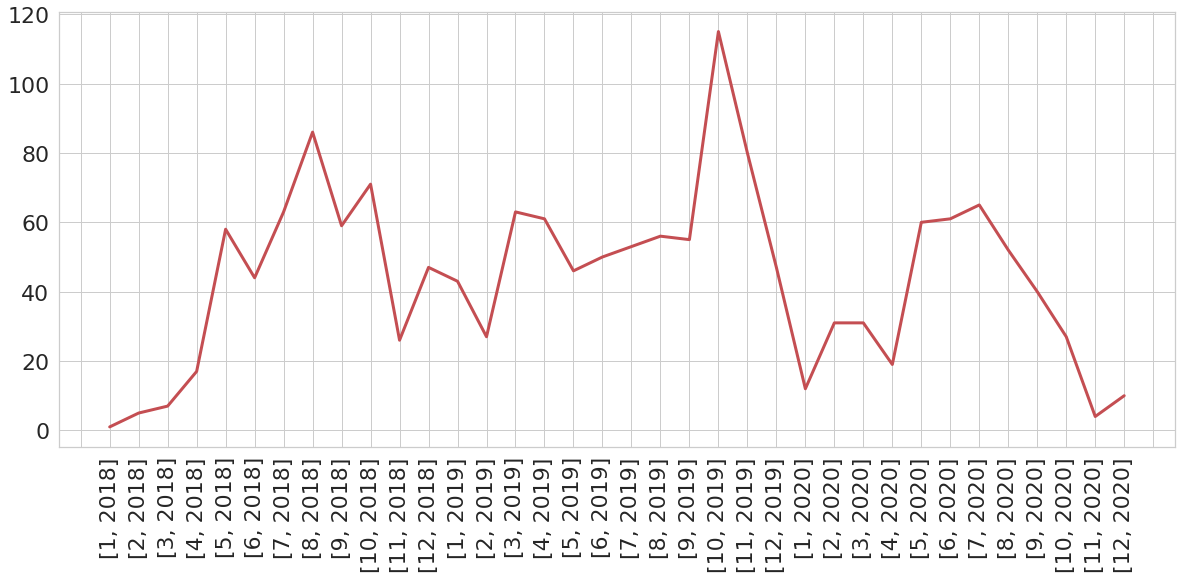

In [ ]:
fig, ax = plt.subplots()

ax.plot(df_month['МесяцГод'], df_month['КоличествоОборот'], color = 'r', linewidth = 3)

# set the interval of major ticks label
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.tick_params(axis='x', labelrotation = 90)

# plt.figure(figsize=(40,3))
fig.set_figwidth(20)
fig.set_figheight(8)

plt.show()

# Simple Exponential Smoothing

In [ ]:
def cv_runSES(data, _test_size, _smoothing_level):
  mae_list = list()
  r2_list = list()
  tcsv = TimeSeriesSplit(n_splits = 3, test_size = _test_size)

  for train_index, test_index in tcsv.split(data):    
    train, test = data.iloc[train_index], data.iloc[test_index]

    mod = SimpleExpSmoothing(train).fit(smoothing_level = _smoothing_level, optimized = True)
    predictions = mod.forecast(len(test))

    mae_list.append(mean_absolute_error(test, predictions))
    r2_list.append(r2_score(test, predictions))

  return {'mae' : np.mean(mae_list), 'r2' : np.mean(r2_list)}

In [ ]:
results = {}

p_sl = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9 , 1]

for i in range(len(p_sl)):
  try:
    results[i] = cv_runSES(df_month['КоличествоОборот'], 3, i)
  except:
    results[i] = None

In [ ]:
results

{0: {'mae': 20.67654418357525, 'r2': -4.01332354073353},
 1: {'mae': 20.444444444444443, 'r2': -2.8898926379599565},
 2: {'mae': 114.0, 'r2': -77.34230888586966},
 3: {'mae': 30.417115092277527, 'r2': -11.196370175286425},
 4: {'mae': 9620962.308553346, 'r2': -2717372569804.9067},
 5: {'mae': 124929850614.0, 'r2': -4.782547896614236e+20},
 6: {'mae': 1119058746954.4802, 'r2': -3.4731219157080043e+22},
 7: {'mae': 2575566126212042.5, 'r2': -2.0659139919895848e+29},
 8: {'mae': 1.2922663399242717e+19, 'r2': -5.249008939525923e+36},
 9: {'mae': 4.998170017893046e+19, 'r2': -7.867401905493739e+37}}

In [10]:
print('Вывод. Минимальное значение метрики MAE = 20.4 и лучшее значение метрики R2 = -2.9 получены при значении smoothing_level = 0.1')

Вывод. Минимальное значение метрики MAE = 20.4 и лучшее значение метрики R2 = -2.9 получены при значении smoothing_level = 0.1


36    39.260263
37    39.260263
38    39.260263
dtype: float64


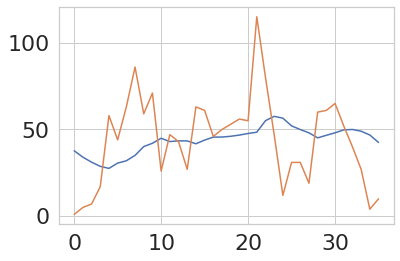

In [ ]:
mod = SimpleExpSmoothing(df_month['КоличествоОборот']).fit(smoothing_level = 0.1, optimized = True)
predictions = mod.forecast(3)
print(predictions)
plt.plot(mod.fittedvalues)
plt.plot(df_month['КоличествоОборот'])
plt.show()

# Double and triple exponential smoothing

In [ ]:
def create_configsES3():
  configs = list()

  trend_parameters = ['add', 'mul', None]
  seasonal_parameters = ['add', 'mul', None]
  damped_trend_parameters = [True, False]
  use_boxcox_parameters = [True, False]
  remove_bias_parameters = [True, False]
  seasonal_periods = [3, 6, 12]
  for t in trend_parameters:
    for s in seasonal_parameters:
      for d in damped_trend_parameters:
        if s != None :
          for sp in seasonal_periods:
            config = dict(trend = t,
                          seasonal = s,
                          damped = d,
                          seasonal_periods = sp)
            configs.append(config)
        else:  
          config = dict(trend = t,
                        seasonal = s,
                        damped = d)        
          
          configs.append(config)
  return configs

In [ ]:
  configs = create_configsES3()
  configs

[{'damped': True, 'seasonal': 'add', 'seasonal_periods': 3, 'trend': 'add'},
 {'damped': True, 'seasonal': 'add', 'seasonal_periods': 6, 'trend': 'add'},
 {'damped': True, 'seasonal': 'add', 'seasonal_periods': 12, 'trend': 'add'},
 {'damped': False, 'seasonal': 'add', 'seasonal_periods': 3, 'trend': 'add'},
 {'damped': False, 'seasonal': 'add', 'seasonal_periods': 6, 'trend': 'add'},
 {'damped': False, 'seasonal': 'add', 'seasonal_periods': 12, 'trend': 'add'},
 {'damped': True, 'seasonal': 'mul', 'seasonal_periods': 3, 'trend': 'add'},
 {'damped': True, 'seasonal': 'mul', 'seasonal_periods': 6, 'trend': 'add'},
 {'damped': True, 'seasonal': 'mul', 'seasonal_periods': 12, 'trend': 'add'},
 {'damped': False, 'seasonal': 'mul', 'seasonal_periods': 3, 'trend': 'add'},
 {'damped': False, 'seasonal': 'mul', 'seasonal_periods': 6, 'trend': 'add'},
 {'damped': False, 'seasonal': 'mul', 'seasonal_periods': 12, 'trend': 'add'},
 {'damped': True, 'seasonal': None, 'trend': 'add'},
 {'damped': F

In [ ]:
def cv_runES(data, _test_size, config):
  mae_list = list()
  r2_list = list()
  tcsv = TimeSeriesSplit(n_splits = 3, test_size = _test_size)

  for train_index, test_index in tcsv.split(data):    
    train, test = data.iloc[train_index], data.iloc[test_index]

    mod = ExponentialSmoothing(train, **config).fit(optimized = True)
    predictions = mod.forecast(len(test))
    
    mae_list.append(mean_absolute_error(test, predictions))
    r2_list.append(r2_score(test, predictions))

  return {'mae' : np.mean(mae_list), 'r2' : np.mean(r2_list)}

In [ ]:
results = {}

for i in range(len(configs)):
  config = configs[i]
  try:
    results[i] = cv_runES(df_month['КоличествоОборот'], 3, config)
  except:
    print(config)
    results[i] = None
    continue  
    
print(results)

{'trend': 'add', 'seasonal': 'mul', 'damped': True, 'seasonal_periods': 3}
{'trend': 'add', 'seasonal': 'mul', 'damped': True, 'seasonal_periods': 6}
{'trend': 'mul', 'seasonal': 'add', 'damped': True, 'seasonal_periods': 12}
{'trend': None, 'seasonal': 'add', 'damped': True, 'seasonal_periods': 3}
{'trend': None, 'seasonal': 'add', 'damped': True, 'seasonal_periods': 6}
{'trend': None, 'seasonal': 'add', 'damped': True, 'seasonal_periods': 12}
{'trend': None, 'seasonal': 'mul', 'damped': True, 'seasonal_periods': 3}
{'trend': None, 'seasonal': 'mul', 'damped': True, 'seasonal_periods': 6}
{'trend': None, 'seasonal': 'mul', 'damped': True, 'seasonal_periods': 12}
{'trend': None, 'seasonal': None, 'damped': True}
{0: {'mae': 20.775139164322287, 'r2': -5.139072245977979}, 1: {'mae': 28.60144080207931, 'r2': -10.286095972827919}, 2: {'mae': 31.350124668485574, 'r2': -12.548850286188122}, 3: {'mae': 23.97150056937906, 'r2': -5.0484269545330065}, 4: {'mae': 27.653692970772436, 'r2': -6.8898

In [ ]:
results

{0: {'mae': 20.775139164322287, 'r2': -5.139072245977979},
 1: {'mae': 28.60144080207931, 'r2': -10.286095972827919},
 2: {'mae': 31.350124668485574, 'r2': -12.548850286188122},
 3: {'mae': 23.97150056937906, 'r2': -5.0484269545330065},
 4: {'mae': 27.653692970772436, 'r2': -6.889838263271481},
 5: {'mae': 34.94421835584013, 'r2': -15.156713151016595},
 6: None,
 7: None,
 8: {'mae': 47.26916049008753, 'r2': -16.224524368288126},
 9: {'mae': 26.35784307205172, 'r2': -5.951565127604973},
 10: {'mae': 41.355968053296664, 'r2': -18.46592381349655},
 11: {'mae': 27.6015784372383, 'r2': -6.8146789653120665},
 12: {'mae': 21.759664070737937, 'r2': -3.908748731791403},
 13: {'mae': 23.032092255893502, 'r2': -4.643271740156398},
 14: {'mae': 23.545318655214086, 'r2': -4.792771978013189},
 15: {'mae': 33.413615247750776, 'r2': -13.705037913282752},
 16: None,
 17: {'mae': 23.05822933899835, 'r2': -3.910406881686583},
 18: {'mae': 28.10603195985426, 'r2': -10.35628022958778},
 19: {'mae': 38.828

In [ ]:
print('Лучшие результаты \n для ', configs[0], ': mae = 20.8, r2 = -5.1 \n для ', configs[12], 'mae = 21.8, r2 = -3.9 \n для ', configs[41], 'mae = 21.5, r2 = -3.6')

Лучшие результаты 
 для  {'trend': 'add', 'seasonal': 'add', 'damped': True, 'seasonal_periods': 3} : mae = 20.8, r2 = -5.1 
 для  {'trend': 'add', 'seasonal': None, 'damped': True} mae = 21.8, r2 = -3.9 
 для  {'trend': None, 'seasonal': None, 'damped': False} mae = 21.5, r2 = -3.6


36    10.201487
37    10.201487
38    10.201487
dtype: float64


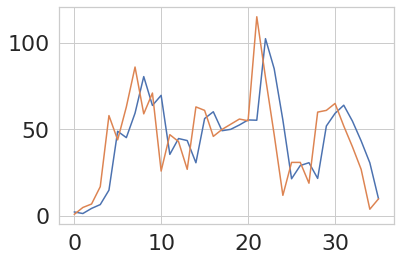

In [ ]:
mod = ExponentialSmoothing(df_month['КоличествоОборот'], damped = False, seasonal = None, trend = None).fit(optimized = True)
predictions = mod.forecast(3)
print(predictions)
plt.plot(mod.fittedvalues)
plt.plot(df_month['КоличествоОборот'])
plt.show()

36    10.392133
37    10.413806
38    10.432184
dtype: float64


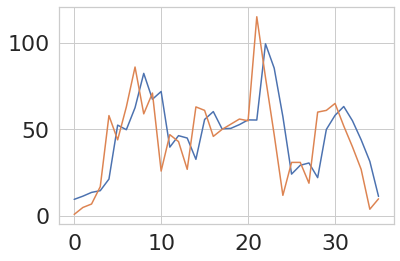

In [ ]:
mod = ExponentialSmoothing(df_month['КоличествоОборот'], damped = True, seasonal = None, trend = 'add').fit(optimized = True)
predictions = mod.forecast(3)
print(predictions)
plt.plot(mod.fittedvalues)
plt.plot(df_month['КоличествоОборот'])
plt.show()

36    12.822545
37    11.201862
38     9.497872
dtype: float64


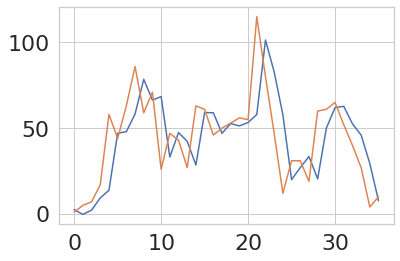

In [ ]:
mod = ExponentialSmoothing(df_month['КоличествоОборот'], damped = True, seasonal = 'add', trend = 'add', seasonal_periods = 3).fit(optimized = True)
predictions = mod.forecast(3)
print(predictions)
plt.plot(mod.fittedvalues)
plt.plot(df_month['КоличествоОборот'])
plt.show()

In [14]:
print('Вывод. \n 1. Не удалось подобрать наиболее приемлимую модель с помощью методов экспоненциального сглживания. \n', 
      'При применении кросс-валидации датасет разбивался на 3 участка и производился прогноз 3-х значений.\n',
      '2. Лучший результат для простого экспоненциального сглаживания получен при smoothing_level = 0.1: MAE = 20.4, метрика r2 - -2.9.\n',
      '3. Лучшие результаты для двойного экспоненциального сглаживания получены при trend = add, damped = True: MAE = 21.8, R2 = -3.9. \n',
      '4. Лучшие результаты для тройного экспоненциального сглаживания получены при trend = add, seasonal = add, seasonal_periods = 3 damped = True: MAE = 21.8, R2 = -3.9 \n')
 

Вывод. 
 1. Не удалось подобрать наиболее приемлимую модель с помощью методов экспоненциального сглживания. 
 При применении кросс-валидации датасет разбивался на 3 участка и производился прогноз 3-х значений.
 2. Лучший результат для простого экспоненциального сглаживания получен при smoothing_level = 0.1: MAE = 20.4, метрика r2 - -2.9.
 3. Лучшие результаты для двойного экспоненциального сглаживания получены при trend = add, damped = True: MAE = 21.8, R2 = -3.9. 
 4. Лучшие результаты для тройного экспоненциального сглаживания получены при trend = add, seasonal = add, seasonal_periods = 3 damped = True: MAE = 21.8, R2 = -3.9 

